# PRICE PREDICTION

---

In this notebook, we will be predicting the price of a coin, using LSTM (Long Short Term Memory) model. We will be using the historical data of the coin to predict the price of the coin in the future. The objective is to train a model able to predict the price of the coin at a given date :
$$ t_{n+1} = f(t_1, t_2, t_3, ..., t_n) $$

Where $t_n$ is the price of the coin at time $n$ and $t_{n+1}$ is the price of the coin at time $n+1$.

We will be using the historical data of the coin to train the model. The data will be split into training and testing data. The model will be trained on the training data and tested on the testing data. The model will be evaluated using different metrics as the Mean Squared Error (MSE) and the Root Mean Squared Error (RMSE).

In [1]:
import sys
sys.path.append("..")

Auto reload the packages when they are modified.

In [2]:
# for auto-reload
%load_ext autoreload
%aimport predictions.etl
%aimport predictions.evaluate
%aimport predictions.models
%aimport retrieval.data_retriever
%autoreload 1

## Import Required Libraries

In [3]:
from predictions.utils import deterministic_mode
from predictions.evaluate import Evaluate
from predictions.models.lstm import LongTermShortMemory
from predictions.etl import ETL

from keras.optimizers import Adam

2024-02-18 14:21:17.616944: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-18 14:21:17.618341: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-18 14:21:17.639005: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 14:21:17.639026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 14:21:17.639562: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Data Preparation

To ensure the reproducibility of the results, we enable the deterministic mode of TensorFlow and NumPy, by using the ```deterministic_mode``` function from our utility script.

We will be using the historical data of the coin to train the model. The data will be split into training and testing data. The model will be trained on the training data and tested on the testing data. The model will be evaluated using different metrics as the Mean Squared Error (MSE) and the Root Mean Squared Error (RMSE).

The data is prepared using the ETL (Extract, Transform, Load) class we have created. The class is used to extract the data from the source, transform the data and load the data into the model. The data is transformed into a format that can be used by the model. The data is normalized and split into training and testing data.

In [4]:
deterministic_mode()
# "../../data/bitcoin/price/bitcoin_chart.csv" 
etl = ETL("../../data/bitcoin/merged.csv", features=['Price'])

## Train the Model

We can then train the model using the training data. We define the different parameters of the model, as the :
- Batch size
- Number of epochs
- optimizer
- loss function

In [6]:
batch_size = 16
learning_rate = 0.00001
epochs = 100
optimizer = Adam(learning_rate=learning_rate)

2024-02-18 14:21:18.590350: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-18 14:21:18.590555: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
model = LongTermShortMemory(intput_shape=etl.test_x.shape[1:])
model.compile(optimizer=optimizer, loss='mean_absolute_error')
model.fit(
    etl.train_x,
    etl.train_y,
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/100
22/22 - 2s - loss: 0.0438 - val_loss: 0.3901 - 2s/epoch - 80ms/step
Epoch 2/100
22/22 - 0s - loss: 0.0412 - val_loss: 0.3834 - 117ms/epoch - 5ms/step
Epoch 3/100
22/22 - 0s - loss: 0.0402 - val_loss: 0.3779 - 117ms/epoch - 5ms/step
Epoch 4/100
22/22 - 0s - loss: 0.0395 - val_loss: 0.3728 - 118ms/epoch - 5ms/step
Epoch 5/100
22/22 - 0s - loss: 0.0391 - val_loss: 0.3683 - 111ms/epoch - 5ms/step
Epoch 6/100
22/22 - 0s - loss: 0.0387 - val_loss: 0.3641 - 122ms/epoch - 6ms/step
Epoch 7/100
22/22 - 0s - loss: 0.0383 - val_loss: 0.3599 - 130ms/epoch - 6ms/step
Epoch 8/100
22/22 - 0s - loss: 0.0379 - val_loss: 0.3558 - 110ms/epoch - 5ms/step
Epoch 9/100
22/22 - 0s - loss: 0.0375 - val_loss: 0.3517 - 114ms/epoch - 5ms/step
Epoch 10/100
22/22 - 0s - loss: 0.0371 - val_loss: 0.3477 - 111ms/epoch - 5ms/step
Epoch 11/100
22/22 - 0s - loss: 0.0366 - val_loss: 0.3436 - 111ms/epoch - 5ms/step
Epoch 12/100
22/22 - 0s - loss: 0.0362 - val_loss: 0.3394 - 113ms/epoch - 5ms/step
Epoch 13/100
22

## Evaluate the Model

We can then evaluate the model using the testing data. We can use different metrics to evaluate the model, as the Mean Squared Error (MSE), the R2 score, or even the MAE (Mean Absolute Error).

In [12]:
prdictions = model.predict(etl.test_x) 
evaluate = Evaluate(etl.inverse_scale(etl.test_y), etl.inverse_scale(prdictions))
evaluate.print()

4/4 [==============================] - 0s 3ms/step
| Metric         |          Value |
|----------------|----------------|
| MSE            |    4.96493e+06 |
| MAE            | 1514.91        |
| R2             |    0.960701    |
| MAPE           |    0.0476903   |
| Variance Ratio |    0.249612    |


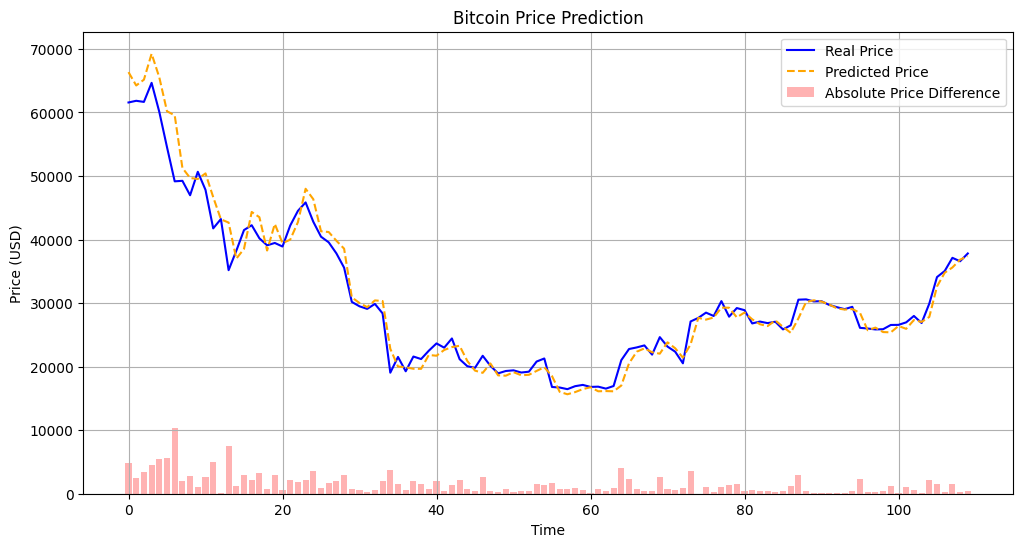

In [10]:
evaluate.plot()